# Particle Swarm Optimisation for Graph Neural Network Architecture Search

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

# import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

This GNN can handle different types of convolutional layers, and both node and graph classification.
The build_conv_model method determines which type of convolutional layer to use for the given task, a graph convolutional network for node classificationtion (GCNConv) and a graph isomorphism network for graph classification (GINConv).
This model is made of 3 covolution layers followed by mean pooling in the case of graph classification, followed by 2 fully connected layers.
Sing our goal here is classification, we use a negative log-likelihood loss function.

In [2]:
class GNN(nn.Module):
    def __init__(self, input_dim, output_dim, task='node', hidden_num = 2, hidden_dim = 32):
        super(GNN, self).__init__()
        self.task = task
        self.convs = nn.ModuleList() #convolution operations
        self.convs.append(pyg_nn.GCNConv(input_dim, hidden_dim))
        # adding convolution an normalisation layers
        for l in range(hidden_num):
            self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim)) # adding 2 linear layers 
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = hidden_num

    def forward(self, data):
        # x = feature matrix = number of nodes * number of node feature dimensions,
        # edge_index = list of the edges in the graph,
        # batch = batch of a graph
        x, edge_index, batch = data.x, data.edge_index, data.batch

        if data.num_node_features == 0: #if there is no feature, use a constant feature
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers): # ,create num_layers convolution layers
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, training=self.training)

        if self.task == 'graph': # if it is a graph classification task, do a pooling
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label) #because classification

In [3]:
def get_acc(loader, model, is_validation=False):
    correct = 0
    total_acc= 0
    
    model.eval()
    for data in loader:
        with torch.no_grad(): # avoid gradient computing for faster results
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = label[mask]
              
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(mask).item()
    
    total_acc = (correct/total)
    return total_acc

In [4]:
def get_loss(loader, opt, model, validation=True):
    total_loss = 0
    for batch in loader:
        opt.zero_grad()
        # get the prediction and the excpeted label
        embedding, pred = model(batch)
        label = batch.y
        if task == 'node':
            if validation:
                mask = batch.val_mask
            else:
                mask = batch.test_mask
            pred = pred[mask]
            label = label[mask]
        loss = model.loss(pred, label)
        loss.backward()
        opt.step()
        total_loss += loss.item() * batch.num_graphs
        
    total_loss /= len(loader.dataset)
    return total_loss

In [5]:
def trainGNN(dataset, task, hidden_num , hidden_dim, lr=0.01):
    trigger = 0
    prev_acc = 0.0
    prev_loss = 1000.0

    if task == 'graph':
        data_size = len(dataset)
        # split data  into traning and testing set
        loader = DataLoader(dataset[:int(data_size * 0.6)], batch_size=64, shuffle=True)
        validation_loader = DataLoader(dataset[int(data_size * 0.6):int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        loader = test_loader
        validation_loader = test_loader

    # build model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = GNN(max(dataset.num_node_features, 1), dataset.num_classes, task=task, hidden_num=hidden_num, hidden_dim=hidden_dim)
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr)
    
    # train for 200 epochs
    for epoch in range(200):
        training_loss = 0
        validation_loss = 0

        model.train()
        for batch in loader:
            opt.zero_grad()
            # get the prediction and the excpeted label
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            training_loss += loss.item() * batch.num_graphs
            
        training_loss /= len(loader.dataset)

        validation_loss =  get_loss(validation_loader, opt, model)
        validation_acc =  get_acc(validation_loader, model, True)
        
        if validation_acc <= prev_acc:
            trigger += 1

        if trigger >= 10:
        # if task == 'node':
            test_acc = get_acc(test_loader, model, False)
            test_loss = get_loss(test_loader, opt, model)
            break
        prev_acc = validation_acc
        
    return model, validation_loss, validation_acc, test_acc, test_loss

In [6]:
import copy
import random

class Particle:
    def __init__(self):
        self.hidden_dim = random.randint(2, 50)
        self.hidden_num = random.randint(2, 10)
        self.lr = round(random.uniform(0.0100, 0.0001), 4)
        # self.parameters = NN_parameters()
        self.cognitiveCoef = 1 # can be changed
        self.socialCoef = 1 # can be changed
        self.informantList = list()
        self.informants_best_err = -1
        self.best_err = -1
        self.best_wb = []
        self.informants_best = [self.hidden_num, self.hidden_dim, self.lr]
        self.err = -1  # Current error (set to -1 at start
        self.velocity_hidden_num = random.random()
        self.velocity_hidden_dim = random.random()
        self.velocity_lr = round(random.uniform(0.0100, 0.0001), 4)

    def setInformants(self, swarm, informantNum, index):
        banned_index = []
        i = 0
        swarm_buffer = copy.deepcopy(swarm)
        banned_index.append(index)
        while i < informantNum:
            informant_chosen = np.random.randint(0, len(swarm_buffer))
            if informant_chosen in banned_index:
                continue
            self.informantList.append(swarm[informant_chosen])
            banned_index.append(informant_chosen)
            i += 1

    def set_informant_best(self):
        for informer in self.informantList:
            if informer.best_err < self.informants_best_err or self.informants_best_err == -1:
                self.informants_best_err = informer.best_err
                self.informants_best = informer.best_wb
    
    def check_error(self, loss):
        self.err = 0
        if self.err < self.best_err or self.best_err == -1:
            self.best_err = self.err
            self.best_wb = [self.hidden_num, self.hidden_dim, self.lr]

    def update_velocity(self):
        inertia_weight = 1

        # Change the velocity values for hidden_num
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[0] - self.hidden_num)
        vel_soc = self.socialCoef * r2 * (self.informants_best[0] - self.hidden_num)
        self.velocity_hidden_num = inertia_weight * self.velocity_hidden_num + vel_soc + vel_cog

        #Change the velocity values for hidden_dim
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[1] - self.hidden_dim)
        vel_soc = self.socialCoef * r2 * (self.informants_best[1] - self.hidden_dim)
        self.velocity_hidden_dim = inertia_weight * self.velocity_hidden_dim + vel_soc + vel_cog

        #Change the velocity values for lr
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[2] - self.lr)
        vel_soc = self.socialCoef * r2 * (self.informants_best[2] - self.lr)
        self.velocity_lr = inertia_weight * self.velocity_lr + vel_soc + vel_cog

    # Update the hidden num and dim
    def change_wb(self):
        self.hidden_num = int(round(self.velocity_hidden_num + self.hidden_num))
        self.hidden_dim = int(round(self.velocity_hidden_dim + self.hidden_dim))
        self.lr = self.velocity_lr + self.lr
        if self.hidden_num < 2:
            self.hidden_num = 2
        if self.hidden_dim < 2:
            self.hidden_dim = 2
        if self.lr <= 0:
            self.lr = 0.0001
        elif self.lr > 1:
            self.lr = 1.0000


In [7]:
class Swarm:
    def __init__(self, informants_number, particle_number):
        self.best_loss = 1000
        self.best_accuracy = 0
        self.informants_number = informants_number
        self.swarm = list()
        self.particle_number = particle_number
        self.average_accuracy = 0
        self.average_loss = 0

        for i in range(self.particle_number):
            new_particle = Particle()
            self.swarm.append(new_particle)
        
        for j in range(len(self.swarm)):
            self.swarm[j].setInformants(self.swarm, self.informants_number, j)
        

    def Optimise(self):
        #Run Optimisation
        for p in range(0,self.particle_number):
            # Find best informants
            self.swarm[p].set_informant_best()
            # Update velocities
            self.swarm[p].update_velocity()
            # Apply velocities to weights and biases
            self.swarm[p].change_wb()

    # For every particle, creates a neural network from the particles weights and biases. And than calculate the output values of the neural network
    def swarm_iteration(self, dataset, task):
        # self.best_loss = 1000
        # self.best_validation_accuracy = 0
        # self.average_validation_loss = 0
        self.best_test_accuracy = 0
        self.average_test_accuracy = 0
        self.average_test_loss = 0
        for p in range(0, int(self.particle_number)):
            # print("Particle num = " + str(p))
            # informants_best[0] = hidden_num
            # informants_best[1] = hidden_dim
            # informants_best[2] = lr

            model, validation_loss, validation_accuracy, test_accuracy, test_loss = trainGNN(dataset, task, int(round(self.swarm[p].hidden_num)), int(round(self.swarm[p].hidden_dim)), self.swarm[p].lr)
            
            if test_accuracy > self.best_test_accuracy:
                self.best_test_loss = test_loss
                self.best_test_accuracy = test_accuracy

            self.average_test_accuracy += test_accuracy
            self.average_test_loss += test_loss
                
            self.swarm[p].check_error(validation_loss)
        
        self.average_test_accuracy = self.average_test_accuracy / int(self.particle_number)
        self.average_test_loss = self.average_test_loss / int(self.particle_number)
        
        return self.best_test_loss, self.best_test_accuracy, self.average_test_loss, self.average_test_accuracy

    # Return the best error of the entire swarn
    def get_best(self):
        swarm_best_err = -1
        for p in self.swarm:
            if p.best_err < swarm_best_err or swarm_best_err == -1:
                swarm_best_err = p.best_err

        return swarm_best_err

    def plot(self, y):
        plt.plot(y)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0,100])
        plt.show()

In [8]:
dataset = Planetoid(root='/tmp/cora', name='cora')
dataset = dataset.shuffle()
task = 'node'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': []
        }

df_cora = pd.DataFrame(data)


# 5 informants, 15 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy, average_loss, average_accuracy = swarm.swarm_iteration(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy}
    df_cora = df_cora.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()

Processing...
Done!


Epoch = 0
loss: 0.5578153729438782, accuracy: 0.679
Epoch = 1
loss: 0.7615028023719788, accuracy: 0.699
Epoch = 2
loss: 0.8013948798179626, accuracy: 0.612
Epoch = 3
loss: 0.40508562326431274, accuracy: 0.763
Epoch = 4
loss: 1.0018051862716675, accuracy: 0.551
Epoch = 5
loss: 1.3170642852783203, accuracy: 0.53
Epoch = 6
loss: 0.4416055977344513, accuracy: 0.747
Epoch = 7
loss: 0.1555618941783905, accuracy: 0.828
Epoch = 8
loss: 0.33863604068756104, accuracy: 0.796
Epoch = 9
loss: 0.35407108068466187, accuracy: 0.823
Epoch = 10
loss: 0.2731708884239197, accuracy: 0.857
Epoch = 11
loss: 0.7053142189979553, accuracy: 0.718
Epoch = 12
loss: 0.039336662739515305, accuracy: 0.825
Epoch = 13
loss: 0.20960162580013275, accuracy: 0.815
Epoch = 14
loss: 0.8550505638122559, accuracy: 0.635
Epoch = 15
loss: 0.34631049633026123, accuracy: 0.81
Epoch = 16
loss: 0.20318074524402618, accuracy: 0.839
Epoch = 17
loss: 0.247155100107193, accuracy: 0.833
Epoch = 18
loss: 0.24983935058116913, accuracy: 0.8

In [9]:
dataset = Planetoid(root='/tmp/pubmed', name = 'pubmed')
dataset = dataset.shuffle()
task = 'node'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': []
        }

df_citeseer = pd.DataFrame(data)


# 5 informants, 15 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy, average_loss, average_accuracy = swarm.swarm_iteration(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy}
    df_citeseer = df_citeseer.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()

Processing...
Done!


Epoch = 0
loss: 0.25698357820510864, accuracy: 0.834
Epoch = 1
loss: 0.3400637209415436, accuracy: 0.795
Epoch = 2
loss: 0.28193822503089905, accuracy: 0.83
Epoch = 3
loss: 0.20691975951194763, accuracy: 0.835
Epoch = 4
loss: 0.30390745401382446, accuracy: 0.828
Epoch = 5
loss: 0.10111421346664429, accuracy: 0.844
Epoch = 6
loss: 0.1417323797941208, accuracy: 0.845
Epoch = 7
loss: 0.10798314213752747, accuracy: 0.834
Epoch = 8
loss: 0.10371191054582596, accuracy: 0.837
Epoch = 9
loss: 0.24650540947914124, accuracy: 0.833
Epoch = 10
loss: 0.29693594574928284, accuracy: 0.811
Epoch = 11
loss: 0.06403651833534241, accuracy: 0.835
Epoch = 12
loss: 0.09876877069473267, accuracy: 0.842
Epoch = 13
loss: 0.17475248873233795, accuracy: 0.836
Epoch = 14
loss: 0.04785639047622681, accuracy: 0.839
Epoch = 15
loss: 0.07588312029838562, accuracy: 0.838
Epoch = 16
loss: 0.2801995873451233, accuracy: 0.81
Epoch = 17
loss: 0.20794188976287842, accuracy: 0.815
Epoch = 18
loss: 0.30984583497047424, accur

In [10]:
# plt.plot(df_cora['epoch'], df_cora['accuracy'], label = "accuracy", color="blue")
# plt.plot(df_cora['epoch'], df_cora['loss'], label = "loss", color="red")
# plt.title('evolution of accuracy through iteration')
# plt.xlabel('epoch')
# # plt.ylabel('accuracy and loss')
# plt.grid()
# plt.legend()
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.show()

In [11]:
# plt.savefig("../figures/cora_node_3_15")

In [12]:
# all_time_best_accuracy = list()
# all_time_best_loss = list()
# tmp_best_accuracy = 0.0
# tmp_best_loss = 1000.0

# for index, row in df_cora.iterrows():
#     if float(row['accuracy']) > tmp_best_accuracy:
#         tmp_best_accuracy = float(row['accuracy'])
#     if float(row['loss']) < tmp_best_loss:
#         tmp_best_loss = float(row['loss'])
#     all_time_best_accuracy.append(tmp_best_accuracy)
#     all_time_best_loss.append(tmp_best_loss)

# # print(all_time_best_accuracy)

# plt.plot(df_cora['epoch'], all_time_best_accuracy, label = "accuracy", color="blue")
# plt.plot(df_cora['epoch'], all_time_best_loss, label = "loss", color="red")
# plt.title('evolution of historical best accuracy and loss')
# plt.xlabel('epoch')
# # plt.ylabel('accuracy and loss')
# plt.grid()
# plt.legend()
# plt.rcParams['figure.figsize'] = [10, 5]
# plt.show()

In [13]:
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
dataset = dataset.shuffle()
task = 'graph'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': []
        }

df_proteins = pd.DataFrame(data)


# 5 informants, 50 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy, average_loss, average_accuracy = swarm.swarm_iteration(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy}
    df_proteins = df_proteins.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()

Extracting /tmp/PROTEINS/PROTEINS/PROTEINS.zip
Processing...
Done!


Epoch = 0
loss: 0.5922759477333103, accuracy: 0.757847533632287
Epoch = 1
loss: 0.5946174651517996, accuracy: 0.7533632286995515
Epoch = 2
loss: 0.5915793041477289, accuracy: 0.757847533632287
Epoch = 3
loss: 0.5702943197814873, accuracy: 0.757847533632287
Epoch = 4
loss: 0.588356921491067, accuracy: 0.7533632286995515
Epoch = 5
loss: 0.5982563979422565, accuracy: 0.7399103139013453
Epoch = 6
loss: 0.5919941762637665, accuracy: 0.7533632286995515
Epoch = 7
loss: 0.5974171340732831, accuracy: 0.7443946188340808
Epoch = 8
loss: 0.588061525415412, accuracy: 0.7443946188340808
Epoch = 9
loss: 0.617756714468045, accuracy: 0.7354260089686099
Epoch = 10
loss: 0.5943213073127472, accuracy: 0.757847533632287
Epoch = 11
loss: 0.5832865481419414, accuracy: 0.7533632286995515
Epoch = 12
loss: 0.5921480203957835, accuracy: 0.7623318385650224
Epoch = 13
loss: 0.5822192954375605, accuracy: 0.7443946188340808
Epoch = 14
loss: 0.5882459202689441, accuracy: 0.7399103139013453
Epoch = 15
loss: 0.60067978

In [14]:
# plt.plot(df_proteins['epoch'], df_proteins['accuracy'], color="blue")
# plt.title('evolution of accuracy through iteration')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.grid()
# plt.legend()
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.show()

In [15]:
# plt.savefig("../figures/proteins_graph_3_15")

In [16]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

data = {'epoch':  [],
        'loss': [],
        'accuracy': [],
        'average_loss': [],
        'average_accuracy': []
        }

df_enzymes = pd.DataFrame(data)


# 5 informants, 50 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy, average_loss, average_accuracy = swarm.swarm_iteration(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy, 'average_loss':average_loss, 'average_accuracy':average_accuracy}
    df_enzymes = df_enzymes.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


Epoch = 0
loss: 1.6883030970891317, accuracy: 0.3416666666666667
Epoch = 1
loss: 1.7096609354019165, accuracy: 0.325
Epoch = 2
loss: 1.7000110864639282, accuracy: 0.3416666666666667
Epoch = 3
loss: 1.6854867537816365, accuracy: 0.35833333333333334
Epoch = 4
loss: 1.6811887264251708, accuracy: 0.35833333333333334
Epoch = 5
loss: 1.6948124011357626, accuracy: 0.3416666666666667
Epoch = 6
loss: 1.6976941426595051, accuracy: 0.30833333333333335
Epoch = 7
loss: 1.7012505610783895, accuracy: 0.35
Epoch = 8
loss: 1.6871809800465902, accuracy: 0.36666666666666664
Epoch = 9
loss: 1.6853634516398113, accuracy: 0.38333333333333336
Epoch = 10
loss: 1.6883323192596436, accuracy: 0.35
Epoch = 11
loss: 1.6974075555801391, accuracy: 0.35833333333333334
Epoch = 12
loss: 1.6971218744913736, accuracy: 0.4
Epoch = 13
loss: 1.6843541383743286, accuracy: 0.375
Epoch = 14
loss: 1.702487866083781, accuracy: 0.35
Epoch = 15
loss: 1.7015806754430136, accuracy: 0.35
Epoch = 16
loss: 1.6933989683787027, accuracy:

In [17]:
# plt.plot(df_enzymes['epoch'], df_enzymes['accuracy'], color="blue")
# plt.title('evolution of accuracy through iteration')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.grid()
# plt.legend()
# plt.rcParams['figure.figsize'] = [10, 10]
# plt.show()

In [18]:
# plt.savefig("../figures/enzymes_graph_3_15")

In [19]:
all_time_best_accuracy_cora = list()
all_time_best_loss_cora = list()
all_time_best_accuracy_citeseer = list()
all_time_best_loss_citeseer = list()
all_time_best_accuracy_proteins = list()
all_time_best_loss_proteins = list()
all_time_best_accuracy_enzymes = list()
all_time_best_loss_enzymes = list()
tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_cora.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_cora.append(tmp_best_accuracy)
    all_time_best_loss_cora.append(tmp_best_loss)

tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_citeseer.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_citeseer.append(tmp_best_accuracy)
    all_time_best_loss_citeseer.append(tmp_best_loss)

tmp_best_accuracy = 0.0

for index, row in df_proteins.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_proteins.append(tmp_best_accuracy)
    all_time_best_loss_proteins.append(tmp_best_loss)

tmp_best_accuracy = 0.0
tmp_best_loss = 1000.0

for index, row in df_enzymes.iterrows():
    if float(row['accuracy']) > tmp_best_accuracy:
        tmp_best_accuracy = float(row['accuracy'])
    if float(row['loss']) < tmp_best_loss:
        tmp_best_loss = float(row['loss'])
    all_time_best_accuracy_enzymes.append(tmp_best_accuracy)
    all_time_best_loss_enzymes.append(tmp_best_loss)



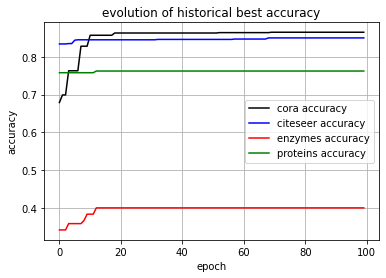

In [20]:
plt.plot(df_cora['epoch'], all_time_best_accuracy_cora, label = "cora accuracy", color="black")
plt.plot(df_citeseer['epoch'], all_time_best_accuracy_citeseer, label = "citeseer accuracy", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_accuracy_enzymes, label = "enzymes accuracy", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_accuracy_proteins, label = "proteins accuracy", color="green")
# plt.plot(df_cora['epoch'], all_time_best_loss, label = "loss", color="red")
plt.title('evolution of historical best accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

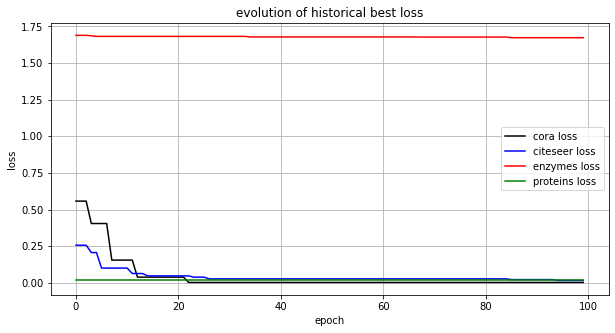

In [21]:
plt.plot(df_cora['epoch'], all_time_best_loss_cora, label = "cora loss", color="black")
plt.plot(df_cora['epoch'], all_time_best_loss_citeseer, label = "citeseer loss", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_loss_enzymes, label = "enzymes loss", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_loss_proteins, label = "proteins loss", color="green")
# plt.plot(df_cora['epoch'], all_time_best_loss, label = "loss", color="red")
plt.title('evolution of historical best loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [22]:
all_time_best_average_accuracy_cora = list()
all_time_best_average_loss_cora = list()
all_time_best_average_accuracy_citeseer = list()
all_time_best_average_loss_citeseer = list()
all_time_best_average_accuracy_proteins = list()
all_time_best_average_loss_proteins = list()
all_time_best_average_accuracy_enzymes = list()
all_time_best_average_loss_enzymes = list()
tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_cora.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_cora.append(tmp_best_average_accuracy)
    all_time_best_average_loss_cora.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_citeseer.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_citeseer.append(tmp_best_average_accuracy)
    all_time_best_average_loss_citeseer.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0

for index, row in df_proteins.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_proteins.append(tmp_best_average_accuracy)
    all_time_best_average_loss_proteins.append(tmp_best_average_loss)

tmp_best_average_accuracy = 0.0
tmp_best_average_loss = 1000.0

for index, row in df_enzymes.iterrows():
    if float(row['average_accuracy']) > tmp_best_average_accuracy:
        tmp_best_average_accuracy = float(row['average_accuracy'])
    if float(row['average_loss']) < tmp_best_average_loss:
        tmp_best_average_loss = float(row['average_loss'])
    all_time_best_average_accuracy_enzymes.append(tmp_best_average_accuracy)
    all_time_best_average_loss_enzymes.append(tmp_best_average_loss)

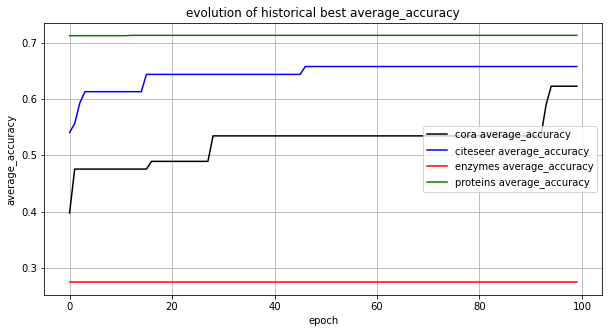

In [23]:
plt.plot(df_cora['epoch'], all_time_best_average_accuracy_cora, label = "cora average_accuracy", color="black")
plt.plot(df_citeseer['epoch'], all_time_best_average_accuracy_citeseer, label = "citeseer average_accuracy", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_average_accuracy_enzymes, label = "enzymes average_accuracy", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_average_accuracy_proteins, label = "proteins average_accuracy", color="green")
plt.title('evolution of historical best average_accuracy')
plt.xlabel('epoch')
plt.ylabel('average_accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

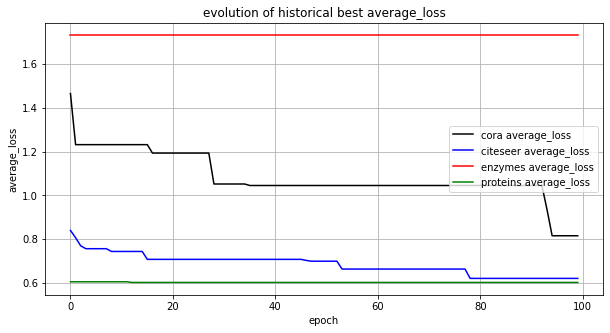

In [24]:
plt.plot(df_cora['epoch'], all_time_best_average_loss_cora, label = "cora average_loss", color="black")
plt.plot(df_citeseer['epoch'], all_time_best_average_loss_citeseer, label = "citeseer average_loss", color="blue")
plt.plot(df_proteins['epoch'], all_time_best_average_loss_enzymes, label = "enzymes average_loss", color="red")
plt.plot(df_enzymes['epoch'], all_time_best_average_loss_proteins, label = "proteins average_loss", color="green")
plt.title('evolution of historical best average_loss')
plt.xlabel('epoch')
plt.ylabel('average_loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

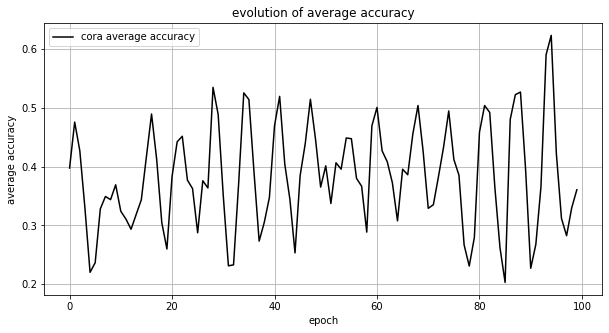

In [25]:
plt.plot(df_cora['epoch'], df_cora["average_accuracy"], label = "cora average accuracy", color="black")
plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

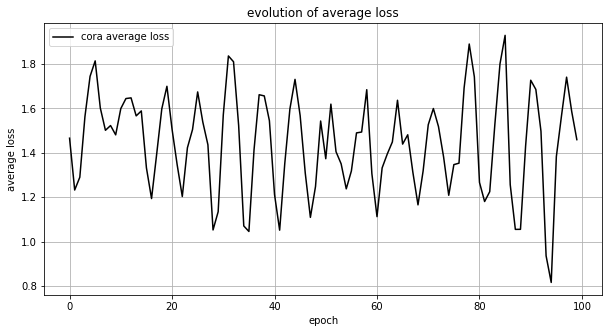

In [26]:
plt.plot(df_cora['epoch'], df_cora["average_loss"], label = "cora average loss", color="black")
plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

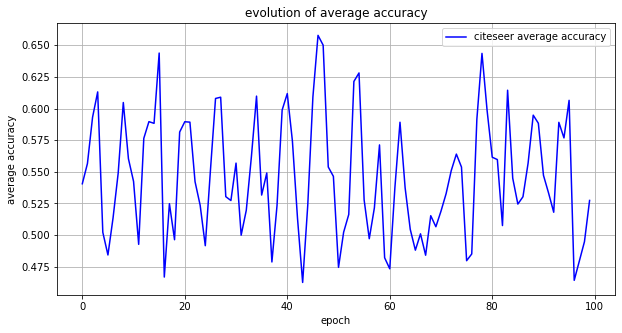

In [27]:
plt.plot(df_citeseer['epoch'], df_citeseer["average_accuracy"], label = "citeseer average accuracy", color="blue")
plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

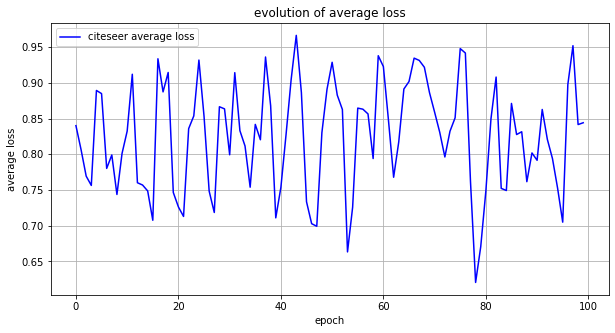

In [28]:
plt.plot(df_citeseer['epoch'], df_citeseer["average_loss"], label = "citeseer average loss", color="blue")
plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

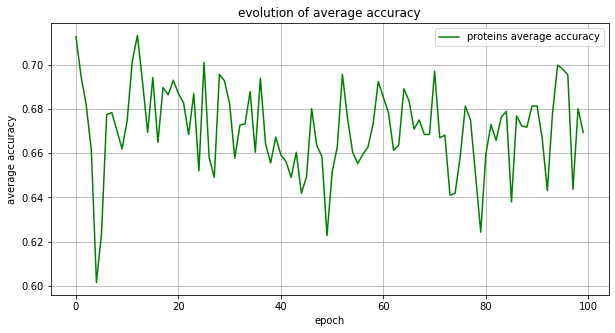

In [29]:
plt.plot(df_proteins['epoch'], df_proteins["average_accuracy"], label = "proteins average accuracy", color="green")
plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

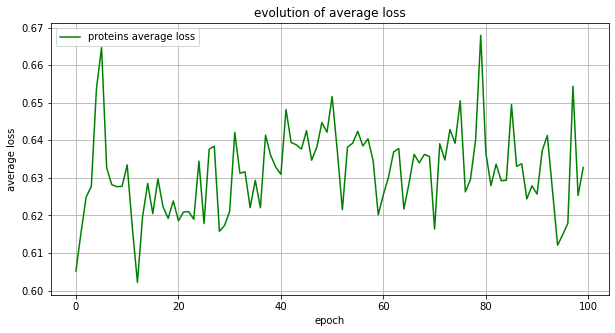

In [30]:
plt.plot(df_proteins['epoch'], df_proteins["average_loss"], label = "proteins average loss", color="green")
plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

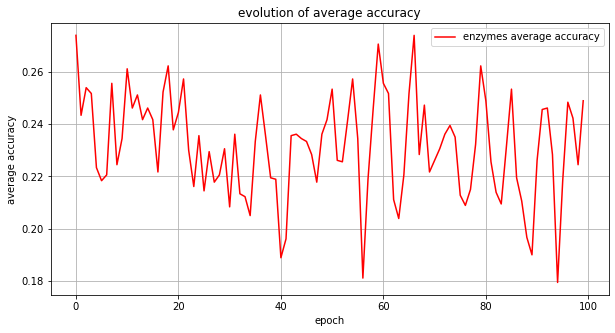

In [31]:
plt.plot(df_enzymes['epoch'], df_enzymes["average_accuracy"], label = "enzymes average accuracy", color="red")
plt.title('evolution of average accuracy')
plt.xlabel('epoch')
plt.ylabel('average accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

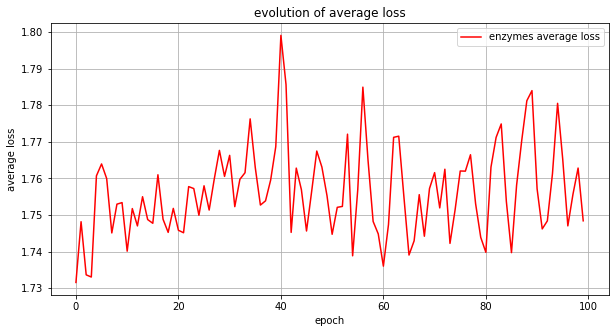

In [32]:
plt.plot(df_enzymes['epoch'], df_enzymes["average_loss"], label = "enzymes average loss", color="red")
plt.title('evolution of average loss')
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()